# EEE6504 - Project 1 #
## Jackson Cornell ##

In [1]:
import math
import time
import scipy.io
import numpy as np
from numpy import random
from scipy import signal
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.stats import levy_stable
from IPython.lib.display import Audio
from statsmodels.graphics.tsaplots import plot_acf

## Functions ##

In [2]:
# Affine projection using gradient descent and non-regularized solution
def APA1(x, d, K, L, mu) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w = w + mu*X@(D - X.T@w)
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

# Affine projection using newton's method and non-regularized solution
def APA2(x, d, K, L, mu, eps) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w = w + mu*X@np.linalg.inv(X.T@X + eps*np.identity(L))@(D - X.T@w)
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

# Affine projection using gradient descent and regularized solution
def APA3(x, d, K, L, mu, lam) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w = (1 - mu*lam)*w + mu*X@(D - X.T@w)
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

# Affine projection using newton's method and regularized solution
def APA4(x, d, K, L, mu, lam) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w =(1 - mu)*w + mu*X@np.linalg.inv(X.T@X + lam*np.identity(L))@D
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

## Read data ##

In [3]:
# read matlab file
speech = scipy.io.loadmat('project1.mat')
fs = speech.get('fs')[0][0]
x = np.array(speech.get('primary')[0])
d = np.array(speech.get('reference')[0])

## 2-tap Filter Analysis ##

In [4]:
# filter data
K = 2
L = 1
mu = 0.001
eps = 1e-6
size = np.size(x) - L - K
w, w_traces, J, y = APA1(x, d, K, L, mu)
w2, w2_traces, J2, y2 = APA2(x, d, K, L, mu, eps)

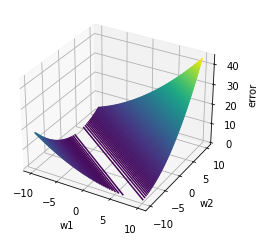

In [5]:
# plot weights performace surface contour
lag = math.floor(fs*1.5)
w_1 = np.linspace(-10, 10, 1000)
w_2 = np.linspace(-10, 10, 1000)
d_t = d[lag]
x_t = [x[lag-1], x[lag]]
e_t = np.zeros([1000,1000])
for i in range(1000) :
    for j in range(1000) :
        e_t[i, j] = (d_t - (w_1[i]*x_t[0] + w_2[j]*x_t[1]))**2
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(w_1, w_2, e_t, 250)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('error');

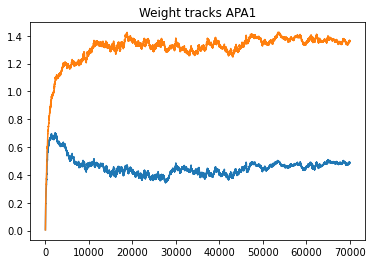

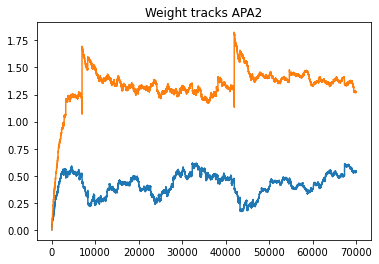

In [6]:
# plot weights track
plt.plot(np.linspace(0, size, size), w_traces[:,0])
plt.plot(np.linspace(0, size, size), w_traces[:,1])
plt.title("Weight tracks APA1")
plt.show()

plt.plot(np.linspace(0, size, size), w2_traces[:,0])
plt.plot(np.linspace(0, size, size), w2_traces[:,1])
plt.title("Weight tracks APA2")
plt.show()

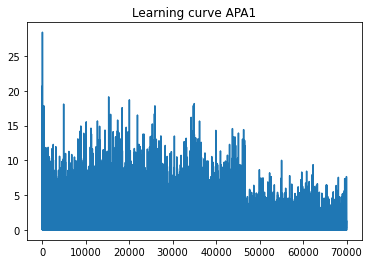

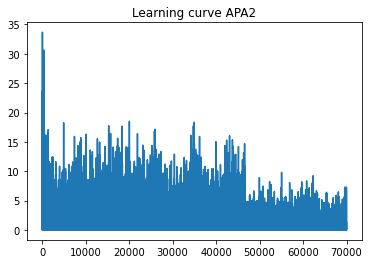

In [7]:
# plot the learning curve
plt.plot(np.linspace(0, size, size), J)
plt.title("Learning curve APA1")
plt.show()

plt.plot(np.linspace(0, size, size), J2)
plt.title("Learning curve APA2")
plt.show()

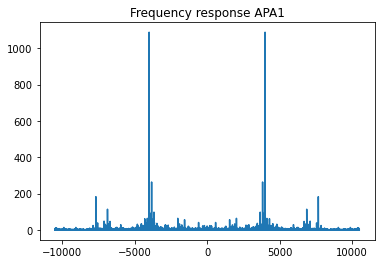

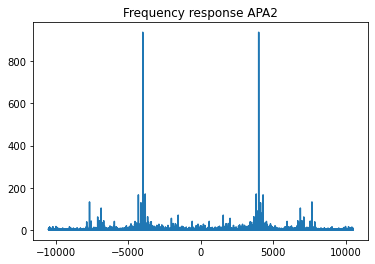

In [8]:
# estimate frequency response
y_t = np.concatenate([np.zeros(L+K),y])
d_freq = abs(np.fft.fft(d))
y_freq = abs(np.fft.fft(y_t))
H = y_freq / d_freq
plt.plot(np.linspace(-math.floor(fs/2), math.floor(fs/2), 70000), H)
plt.title("Frequency response APA1")
plt.show()

y2_t = np.concatenate([np.zeros(L+K),y2])
y2_freq = abs(np.fft.fft(y2_t))
H2 = y2_freq / d_freq
plt.plot(np.linspace(-math.floor(fs/2), math.floor(fs/2), 70000), H2)
plt.title("Frequency response APA2")
plt.show()

In [9]:
# estimate SNR using ERLE
d_acf = np.correlate(d, d, mode='full')[0]
y_acf = np.correlate(y, y, mode='full')[0]
print("APA1 ERLE SNR Improvement (dB):", 10*math.log10(abs(d_acf / y_acf)))

y2_acf = np.correlate(y2, y2, mode='full')[0]
print("APA2 ERLE SNR Improvement (dB):", 10*math.log10(abs(d_acf / y2_acf)))

APA1 ERLE SNR Improvement (dB): 8.760316800887626
APA2 ERLE SNR Improvement (dB): 30.409528346257268


In [10]:
# output audio
Audio(y, rate=fs)

In [11]:
# output audio
Audio(y2, rate=fs)

## Hyperparameter Analysis ##

In [12]:
# find optimal L
l_arr = np.array([1, 5, 10, 15, 25])
for l in l_arr :
    w, w_traces, J, y = APA1(x, d, K, l, mu)
    w2, w2_traces, J2, y2 = APA2(x, d, K, l, mu, eps)
    y_acfk = np.correlate(y, y, mode='full')[0]
    y2_acfk = np.correlate(y2, y2, mode='full')[0]
    print("APA1 ERLE SNR Improvement (dB), L =", l, ":", 10*math.log10(abs(d_acf / y_acfk)))
    print("APA2 ERLE SNR Improvement (dB), L =", l, ":", 10*math.log10(abs(d_acf / y2_acfk)))
    
L = 10
L2 = 1

APA1 ERLE SNR Improvement (dB), L = 1 : 8.760316800887626
APA2 ERLE SNR Improvement (dB), L = 1 : 30.409528346257268
APA1 ERLE SNR Improvement (dB), L = 5 : 8.135032872997197
APA2 ERLE SNR Improvement (dB), L = 5 : 4.778747377372045
APA1 ERLE SNR Improvement (dB), L = 10 : 15.13345257269631
APA2 ERLE SNR Improvement (dB), L = 10 : 14.796987250264015
APA1 ERLE SNR Improvement (dB), L = 15 : 4.282019342190497
APA2 ERLE SNR Improvement (dB), L = 15 : 5.50192051383113
APA1 ERLE SNR Improvement (dB), L = 25 : 10.211686716961824
APA2 ERLE SNR Improvement (dB), L = 25 : 11.456056114903978


In [13]:
# iterate through several filter orders to find optimal weighting
K = np.array([18, 19, 20, 21, 22])
for k in K :
    w, w_traces, J, y = APA1(x, d, k, L, mu)
    y_acfk = np.correlate(y, y, mode='full')[0]
    print("APA1 ERLE SNR Improvement (dB), K =", k, ":", 10*math.log10(abs(d_acf / y_acfk)))

K = np.array([2, 5, 10, 15, 20, 30])
for k in K :
    w, w_traces, J, y = APA2(x, d, k, L2, mu, eps)
    y_acfk = np.correlate(y, y, mode='full')[0]
    print("APA2 ERLE SNR Improvement (dB), K =", k, ":", 10*math.log10(abs(d_acf / y_acfk)))
    
K = 19
K2 = 2

APA1 ERLE SNR Improvement (dB), K = 18 : 25.37318605087771
APA1 ERLE SNR Improvement (dB), K = 19 : 32.75842773929312
APA1 ERLE SNR Improvement (dB), K = 20 : 24.162449371750018
APA1 ERLE SNR Improvement (dB), K = 21 : 18.154681589367947
APA1 ERLE SNR Improvement (dB), K = 22 : 14.890173018855267
APA2 ERLE SNR Improvement (dB), K = 2 : 30.409528346257268
APA2 ERLE SNR Improvement (dB), K = 5 : 18.130099758713822
APA2 ERLE SNR Improvement (dB), K = 10 : 11.246480417584714
APA2 ERLE SNR Improvement (dB), K = 15 : 0.12708971702342511
APA2 ERLE SNR Improvement (dB), K = 20 : -0.8676858520671897
APA2 ERLE SNR Improvement (dB), K = 30 : 8.412332273744799


In [14]:
# find optimal psuedo-inverse parameter
eps_arr = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
for e in eps_arr :
    w, w_traces, J, y = APA2(x, d, K2, L2, mu, eps=e)
    y_acfe = np.correlate(y, y, mode='full')[0]
    print("APA2 ERLE SNR Improvement (dB), eps =", e, ":", 10*math.log10(abs(d_acf / y_acfe)))
eps = 1e-6

APA2 ERLE SNR Improvement (dB), eps = 1e-06 : 30.409528346257268
APA2 ERLE SNR Improvement (dB), eps = 1e-05 : 17.47916642683491
APA2 ERLE SNR Improvement (dB), eps = 0.0001 : 11.020942957837622
APA2 ERLE SNR Improvement (dB), eps = 0.001 : 9.097515427519385
APA2 ERLE SNR Improvement (dB), eps = 0.01 : 8.398487771118257
APA2 ERLE SNR Improvement (dB), eps = 0.1 : 8.286379485138381


In [23]:
# perform APA with K=19
w, w_traces, J, y = APA1(x, d, K, L, mu)
w2, w2_traces, J2, y2 = APA2(x, d, K2, L2, mu, eps)

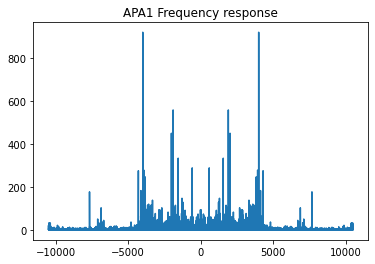

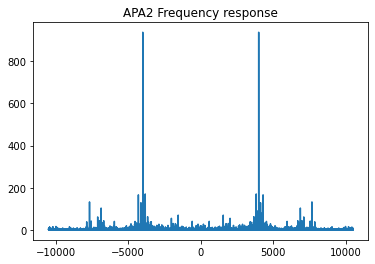

In [24]:
# estimate frequency response
y_t = np.concatenate([np.zeros(L+K),y])
d_freq = abs(np.fft.fft(d))
y_freq = abs(np.fft.fft(y_t))
H = y_freq / d_freq
plt.plot(np.linspace(-math.floor(fs/2), math.floor(fs/2), 70000), H)
plt.title("APA1 Frequency response")
plt.show()

y2_t = np.concatenate([np.zeros(L2+K2),y2])
y2_freq = abs(np.fft.fft(y2_t))
H2 = y2_freq / d_freq
plt.plot(np.linspace(-math.floor(fs/2), math.floor(fs/2), 70000), H2)
plt.title("APA2 Frequency response")
plt.show()

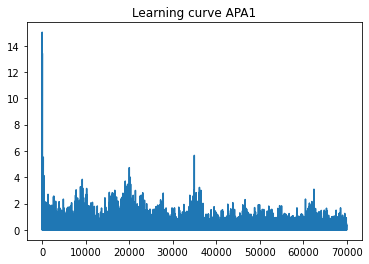

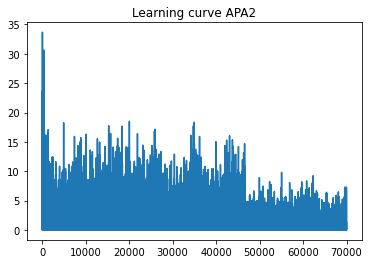

In [27]:
#plot learning curves
plt.plot(np.linspace(0, np.size(x)-L-K, np.size(x)-L-K), J)
plt.title("Learning curve APA1")
plt.show()

plt.plot(np.linspace(0, np.size(x)-L2-K2, np.size(x)-L2-K2), J2)
plt.title("Learning curve APA2")
plt.show()

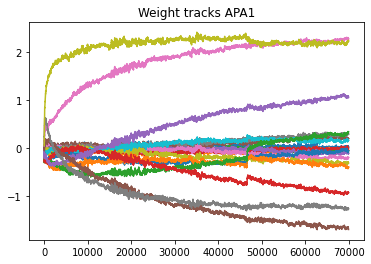

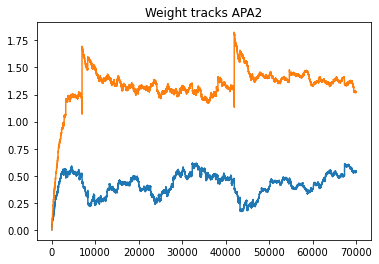

In [28]:
# plot weight tracks
for i in range(K) :
    plt.plot(np.linspace(0, np.size(x)-L-K, np.size(x)-L-K), w_traces[:,i])
plt.title("Weight tracks APA1")
plt.show()

plt.plot(np.linspace(0, np.size(x)-L2-K2, np.size(x)-L2-K2), w2_traces[:,0])
plt.plot(np.linspace(0, np.size(x)-L2-K2, np.size(x)-L2-K2), w2_traces[:,1])
plt.title("Weight tracks APA2")
plt.show()

In [17]:
# compute SNR improvement
d_acf = np.correlate(d, d, mode='full')[0]
y_acf = np.correlate(y, y, mode='full')[0]
print("APA1 ERLE SNR Improvement (dB):", 10*math.log10(abs(d_acf / y_acf)))

y2_acf = np.correlate(y2, y2, mode='full')[0]
print("APA2 ERLE SNR Improvement (dB):", 10*math.log10(abs(d_acf / y2_acf)))

APA1 ERLE SNR Improvement (dB): 32.75842773929312
APA2 ERLE SNR Improvement (dB): 30.409528346257268


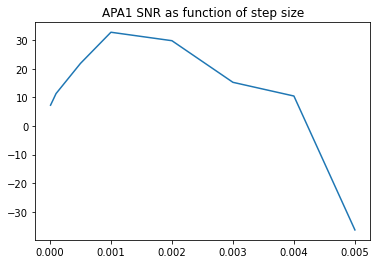

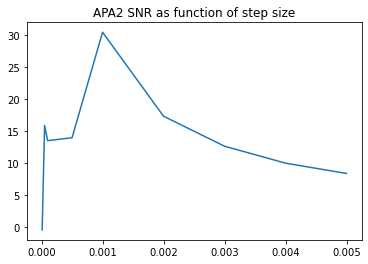

In [18]:
# evaluate performance as function of step size
mu_arr = np.array([1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3])
ERLE = np.zeros(9)
ERLE2 = np.zeros(9)
i = 0
for m in mu_arr :
    w, w_traces, J, y = APA1(x, d, K, L, m)
    w2, w2_traces, J2, y2 = APA2(x, d, K2, L2, m, eps)
    y_acfk = np.correlate(y, y, mode='full')[0]
    ERLE[i] = 10*math.log10(abs(d_acf / y_acfk))
    y2_acfk = np.correlate(y2, y2, mode='full')[0]
    ERLE2[i] = 10*math.log10(abs(d_acf / y2_acfk))
    i += 1
    
mu = 0.001
    
# plot ERLE SNR as function of step size
plt.plot(mu_arr, ERLE)
plt.title("APA1 SNR as function of step size")
plt.show()

plt.plot(mu_arr, ERLE2)
plt.title("APA2 SNR as function of step size")
plt.show()

In [32]:
# APA1 output audio with optimal parameters
mu = 0.001
w, w_traces, J, y = APA1(x, d, K, L, mu)
print("Misadjustment:", math.log10((np.average(J) - np.amin(J)) / np.amin(J)))
Audio(y, rate=fs)

Misadjustment: 8.540982646538387


In [33]:
# APA1 output audio with APA2's optimal parameters
w, w_traces, J, y = APA1(x, d, K2, L2, mu)
print("Misadjustment:", math.log10((np.average(J) - np.amin(J)) / np.amin(J)))
Audio(y, rate=fs)

Misadjustment: 9.777791002740045


In [34]:
# APA2 output audio with optimal parameters
eps = 1e-6
w, w_traces, J, y = APA2(x, d, K2, L2, mu, eps)
print("Misadjustment:", math.log10((np.average(J2) - np.amin(J2)) / np.amin(J2)))
Audio(y, rate=fs)

Misadjustment: 9.705330522197736
